In [37]:
# Importing the Keras libraries and packages

from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import keras
from natsort import natsorted

In [38]:
train_dir = "/kaggle/input/american-sign-language-recognition/training_set"
eval_dir = "/kaggle/input/american-sign-language-recognition/test_set"

In [39]:
def get_images(images_path):

    array_images = []
    train_or_test_folder = os.listdir(images_path)

    for folder in natsorted(train_or_test_folder):
        single_folder = os.path.join(images_path, folder)

        for file in os.listdir(single_folder):
            filepath = os.path.join(single_folder, file)

            if filepath.lower().endswith(('.jpeg', '.jpg')):
                image = cv2.resize(cv2.imread(filepath), (64, 64))
                # Array von TensorFlow Tensoren
                array_images.append(image)

    images = np.array(array_images)
    
    return images

In [40]:
def get_label(images_path):

    array_label = []
    for folder in natsorted(os.listdir(images_path)):
        label = int(folder)

        for file in os.listdir(os.path.join(images_path, folder)):
            array_label.append(label)
    labels = np.array(array_label)
        
    return labels

In [41]:
images = get_images("./resized_images/train")
labels = get_label("./resized_images/train")

X_eval = get_images("./resized_images/test")
y_eval = get_label("./resized_images/test")

In [42]:
uniq_labels = natsorted(os.listdir("./resized_images/train"))
print(len(uniq_labels))

26


In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, stratify = labels)
# Trainingsbilder, Testbilder, Trainingslabels, Testlabels

n = len(uniq_labels)
train_n = len(X_train)
test_n = len(X_test)

print("Total number of symbols: ", n)
print("Anzahl Trainingsbilder: " , train_n)
print("Anzahl Testbilder: ", test_n)

eval_n = len(X_eval)
print("Anzahl Evaluierungsbilder: ", eval_n)

Total number of symbols:  26
Anzahl Trainingsbilder:  6080
Anzahl Testbilder:  1521
Anzahl Evaluierungsbilder:  1812


In [44]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_eval = keras.utils.to_categorical(y_eval)

In [45]:
print(y_train[0])
print(len(y_train[0]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0.]
27


In [46]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
X_eval = X_eval.astype('float32')/255.0


In [47]:
#Initialising vgg16 
classifier_vgg16 = VGG16(input_shape= (64,64,3),include_top=False,weights='imagenet')

In [48]:
#Initialising vgg16 
classifier_resnet = ResNet50(input_shape= (64,64,3),include_top=False,weights='imagenet')

In [49]:
#don't train existing weights for vgg16
for layer in classifier_vgg16.layers:
    layer.trainable = False

#don't train existing weights for resnet50
for layer in classifier_resnet.layers:
    layer.trainable = False

In [50]:
classifier1 = classifier_vgg16.output#head mode
classifier1 = Flatten()(classifier1)#adding layer of flatten
classifier1 = Dense(units=256, activation='relu')(classifier1)
classifier1 = Dropout(0.6)(classifier1)
classifier1 = Dense(units=27, activation='softmax')(classifier1)

model = Model(inputs = classifier_vgg16.input , outputs = classifier1)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
classifier2 = classifier_resnet.output#head mode
classifier2 = Flatten()(classifier2)#adding layer of flatten
classifier2 = Dropout(0.6)(classifier2)
classifier2 = Dense(units=27, activation='softmax')(classifier2)

model2 = Model(inputs = classifier_resnet.input , outputs = classifier2)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 27)             │         6,939 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,246,171 (58.16 MB)

 Trainable params: 531,483 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [53]:
model2.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_3_c

 Total params: 23,808,923 (90.82 MB)

 Trainable params: 221,211 (864.11 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [54]:
#fit the model
#it will take some time to train
history = model.fit(X_train, y_train, epochs =5, batch_size = 64,validation_data=(X_test,y_test))

Epoch 1/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 49s 490ms/step - accuracy: 0.1462 - loss: 2.9756 - val_accuracy: 0.5371 - val_loss: 1.9074
Epoch 2/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 45s 474ms/step - accuracy: 0.3891 - loss: 1.9963 - val_accuracy: 0.6443 - val_loss: 1.4159
Epoch 3/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 46s 483ms/step - accuracy: 0.5178 - loss: 1.6070 - val_accuracy: 0.7350 - val_loss: 1.1401
Epoch 4/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 46s 485ms/step - accuracy: 0.5966 - loss: 1.3304 - val_accuracy: 0.7627 - val_loss: 0.9816
Epoch 5/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 46s 490ms/step - accuracy: 0.6501 - loss: 1.1788 - val_accuracy: 0.7968 - val_loss: 0.8602


In [55]:
#fit the model
#it will take some time to train
history2 = model2.fit(X_train, y_train, epochs =5, batch_size = 64,validation_data=(X_test,y_test))

Epoch 1/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 46s 398ms/step - accuracy: 0.0711 - loss: 3.3951 - val_accuracy: 0.1979 - val_loss: 2.7571
Epoch 2/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 35s 373ms/step - accuracy: 0.1524 - loss: 2.8296 - val_accuracy: 0.3011 - val_loss: 2.5510
Epoch 3/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 35s 370ms/step - accuracy: 0.2013 - loss: 2.6558 - val_accuracy: 0.3274 - val_loss: 2.4413
Epoch 4/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 35s 374ms/step - accuracy: 0.2261 - loss: 2.5507 - val_accuracy: 0.3333 - val_loss: 2.3654
Epoch 5/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 34s 359ms/step - accuracy: 0.2316 - loss: 2.4835 - val_accuracy: 0.3550 - val_loss: 2.3055


In [56]:
# Saving the model of vgg16
model.save('model_vgg16.h5')
# Saving the model of resnet
model2.save('model_resnet.h5')

In [57]:
score = model.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model.evaluate(x = X_eval, y = y_eval, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 79.684 %
Accuracy for evaluation images: 15.784 %


In [58]:
score = model2.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model2.evaluate(x = X_eval, y = y_eval, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 35.503 %
Accuracy for evaluation images: 11.258 %


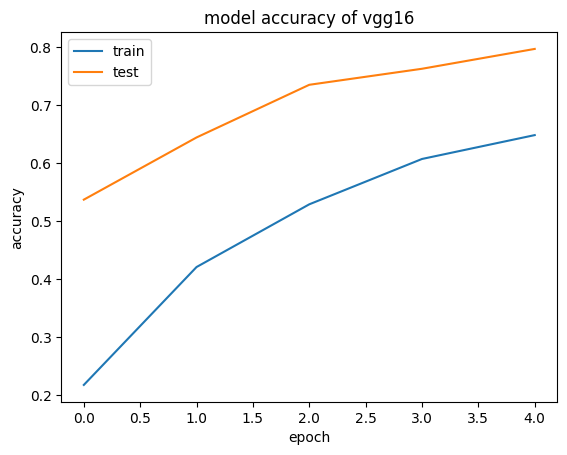

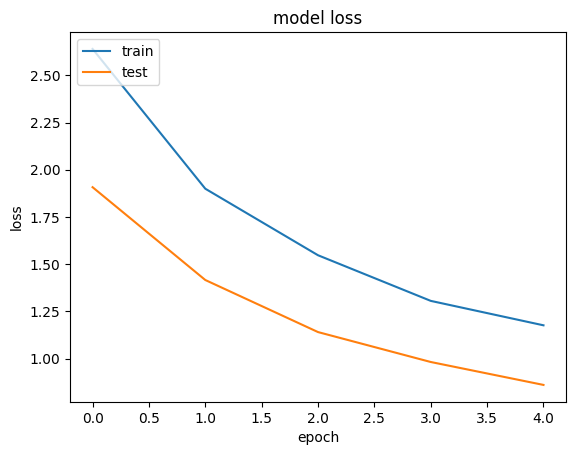

In [59]:

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy of vgg16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

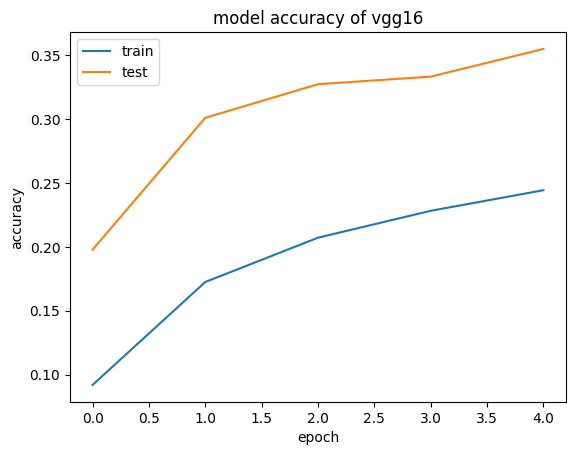

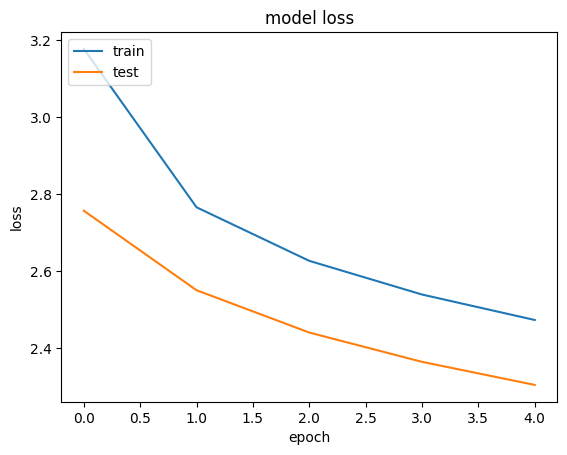

In [60]:
#vgg16
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy of vgg16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

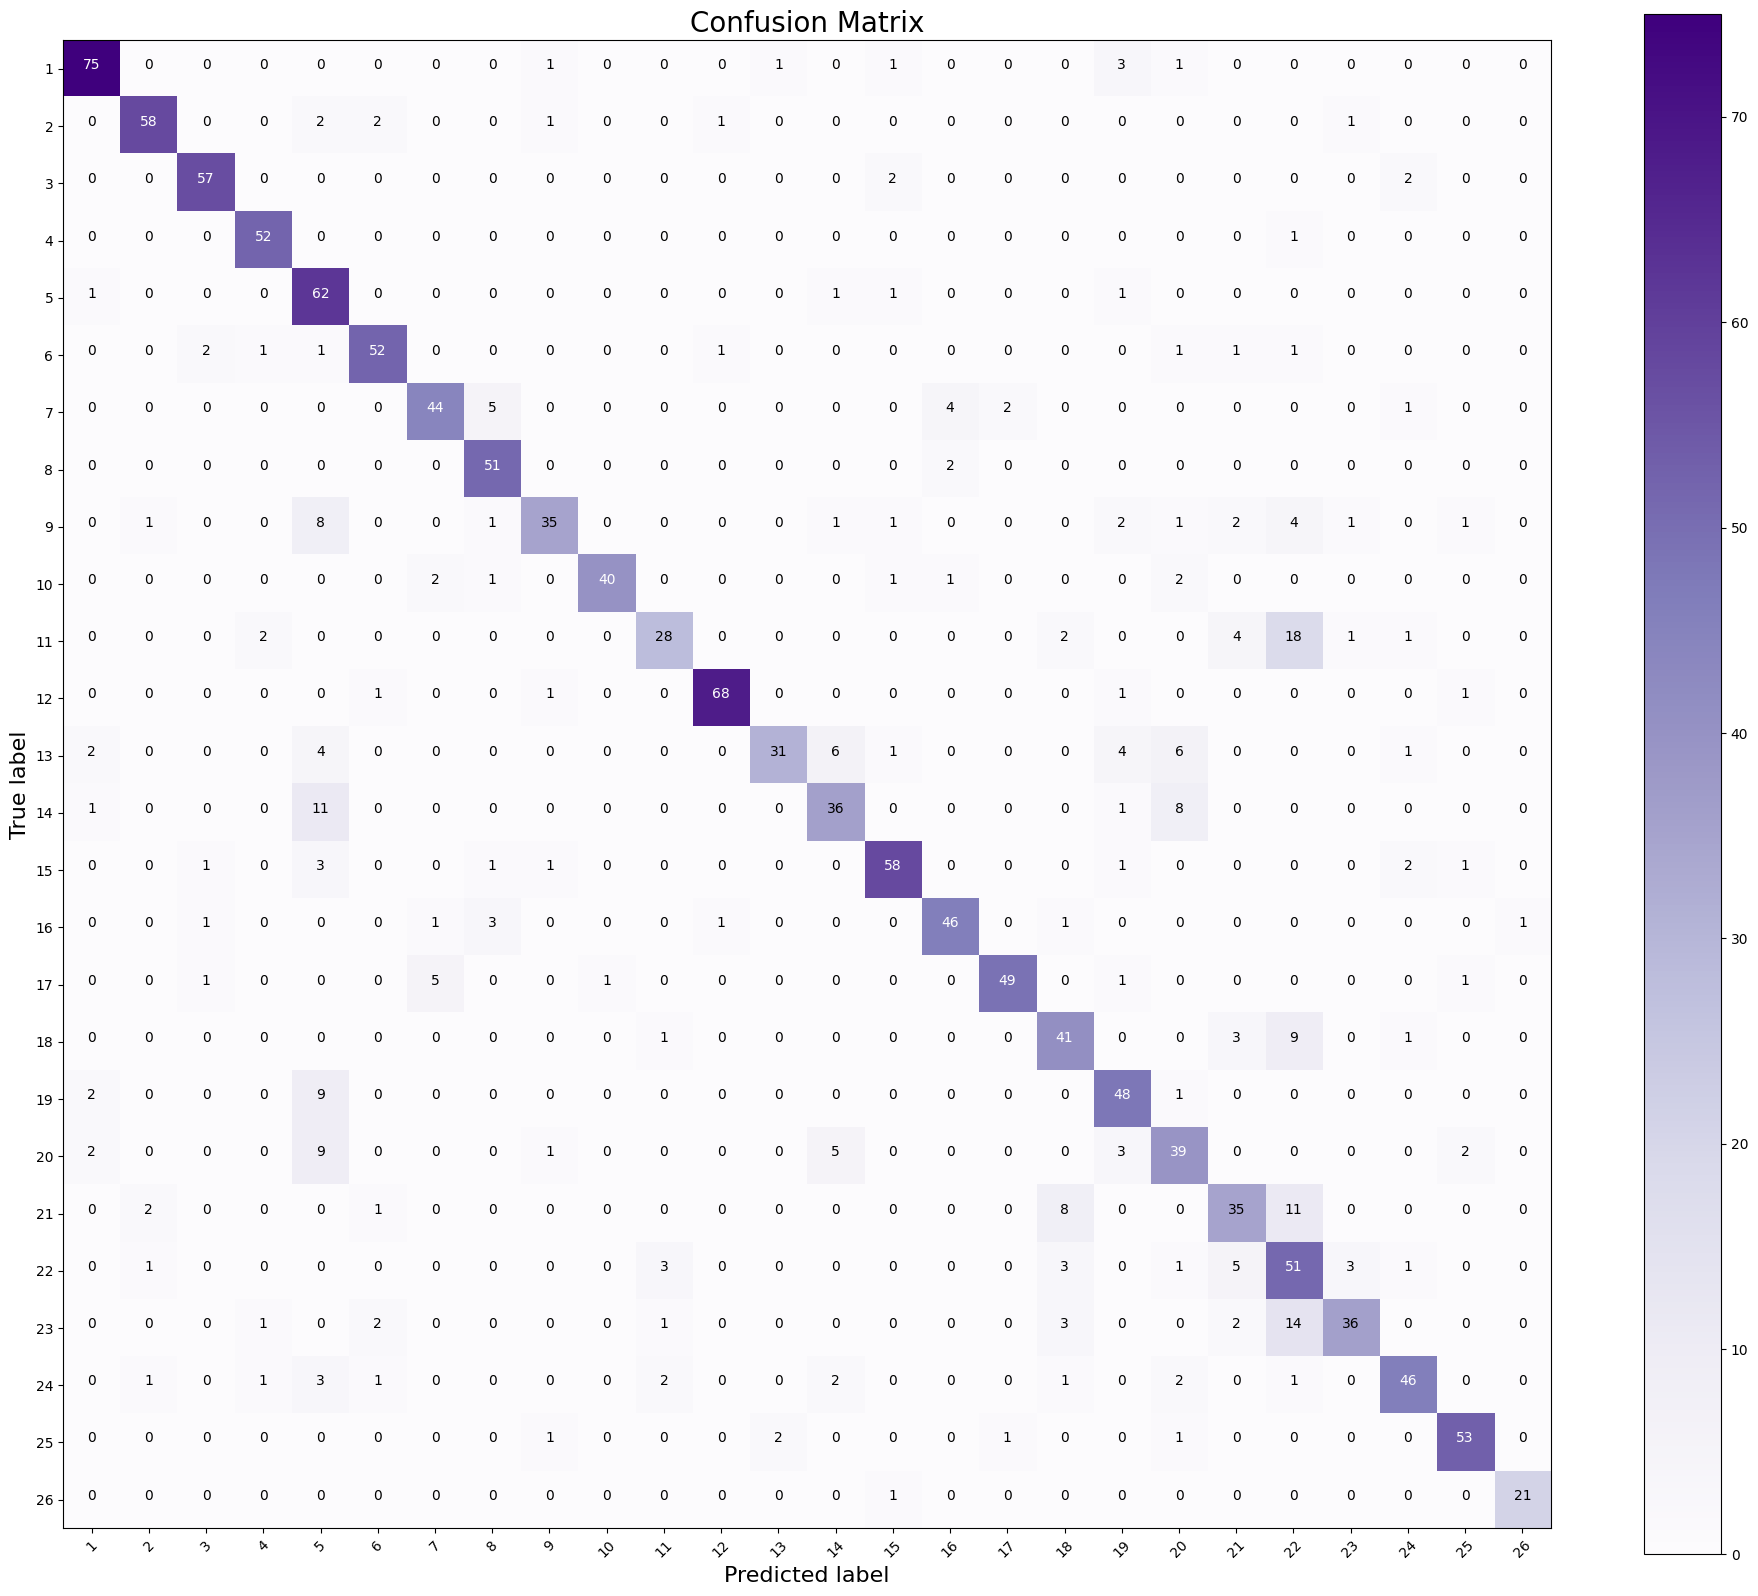

In [61]:
#Helper function to plot confusion matrix
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

from sklearn.metrics import confusion_matrix
import itertools

y_test_pred = model.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

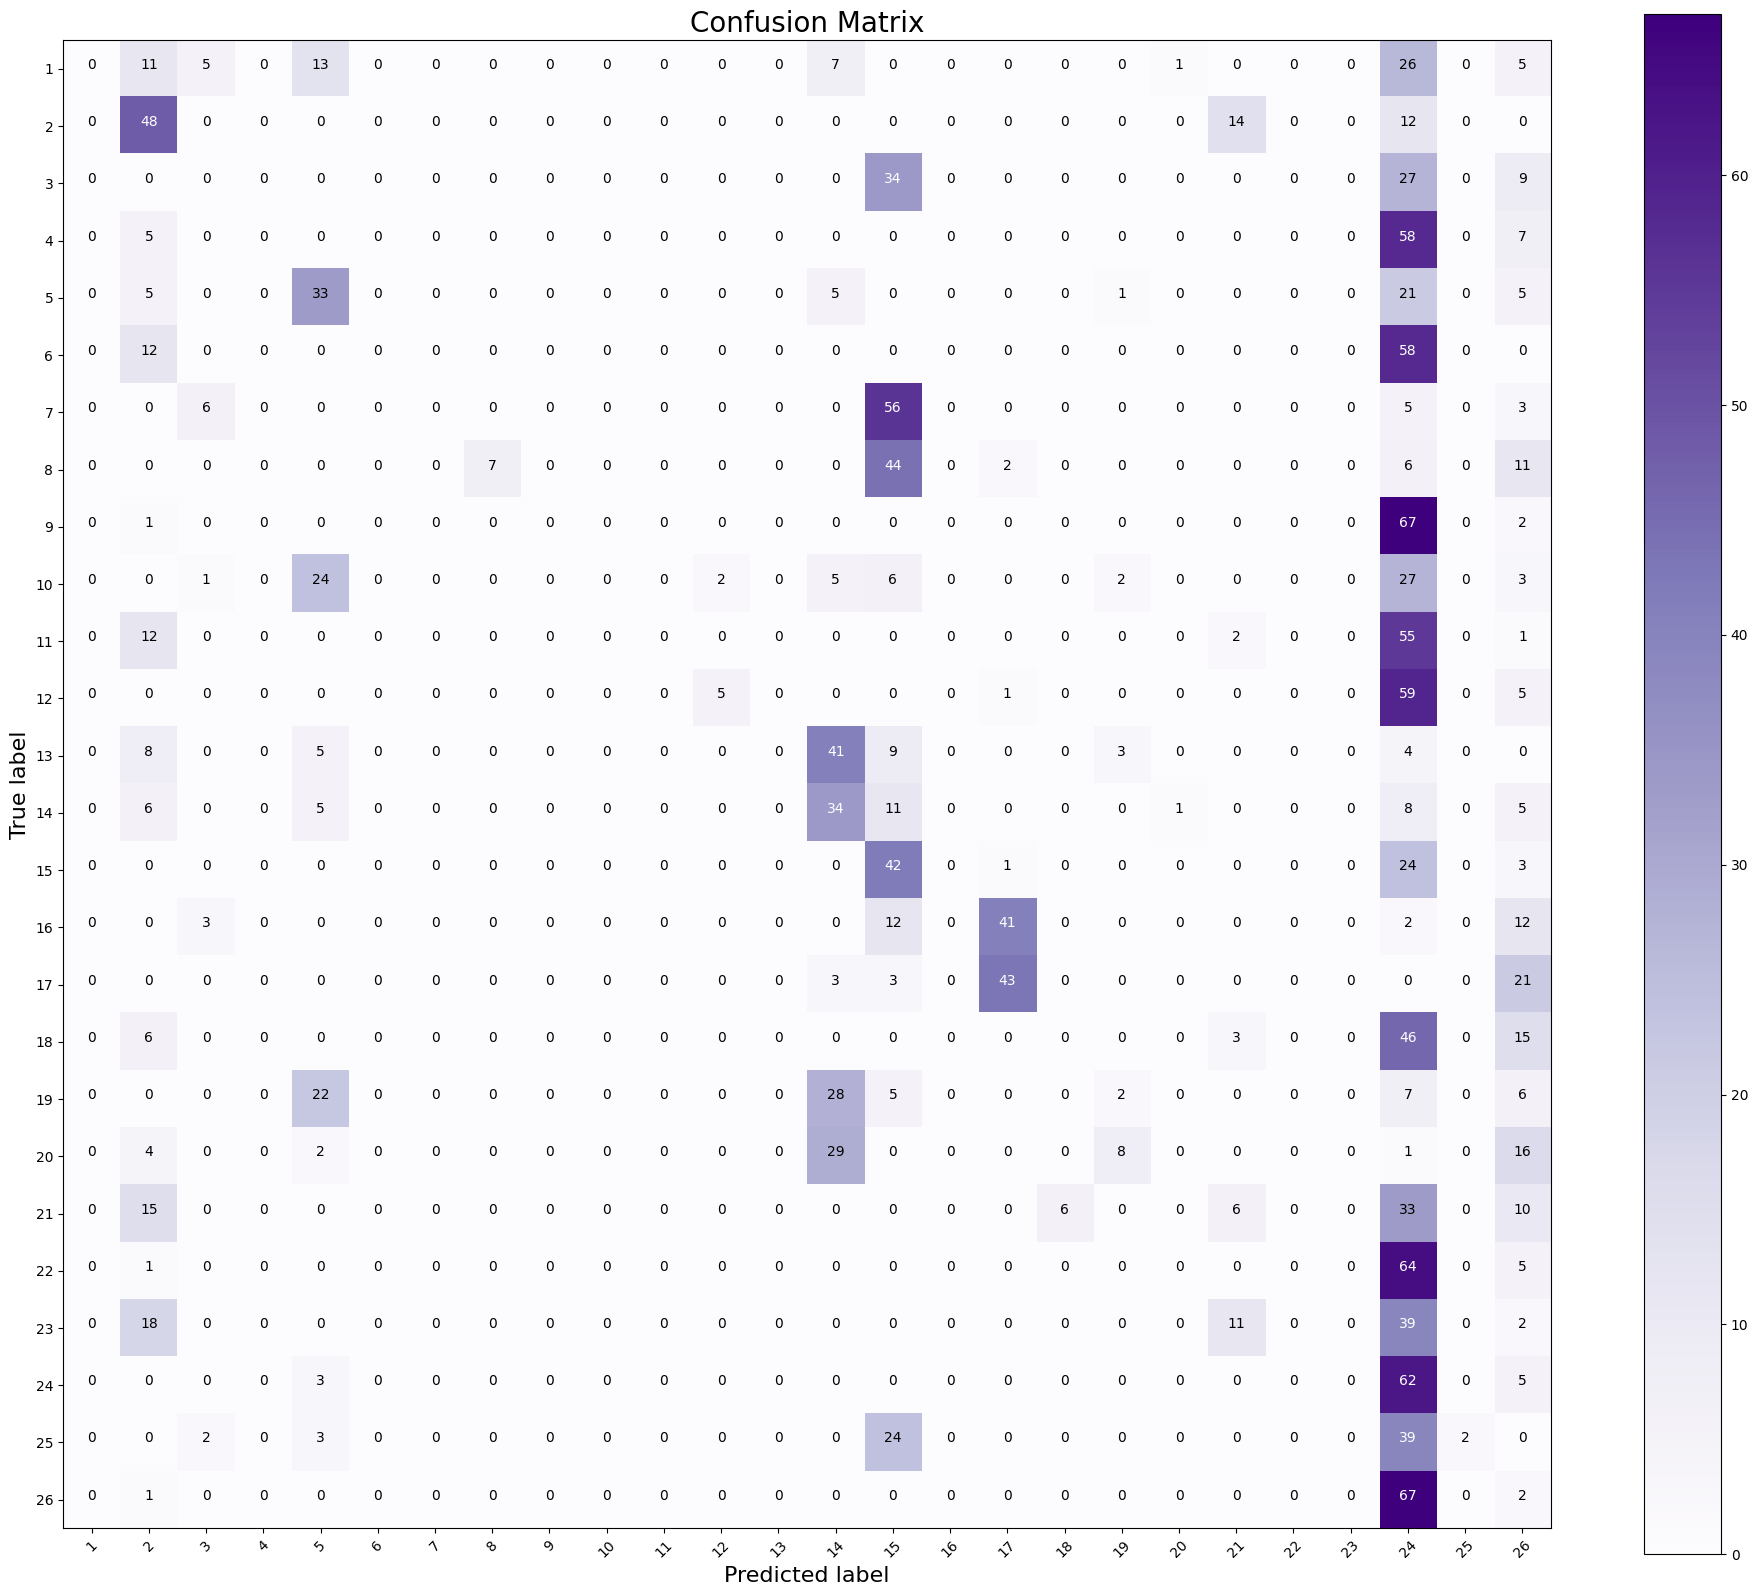

In [62]:
y_eval_pred = model.predict(X_eval, batch_size = 512,verbose = 0)
plot_confusion_matrix(y_eval, y_eval_pred)

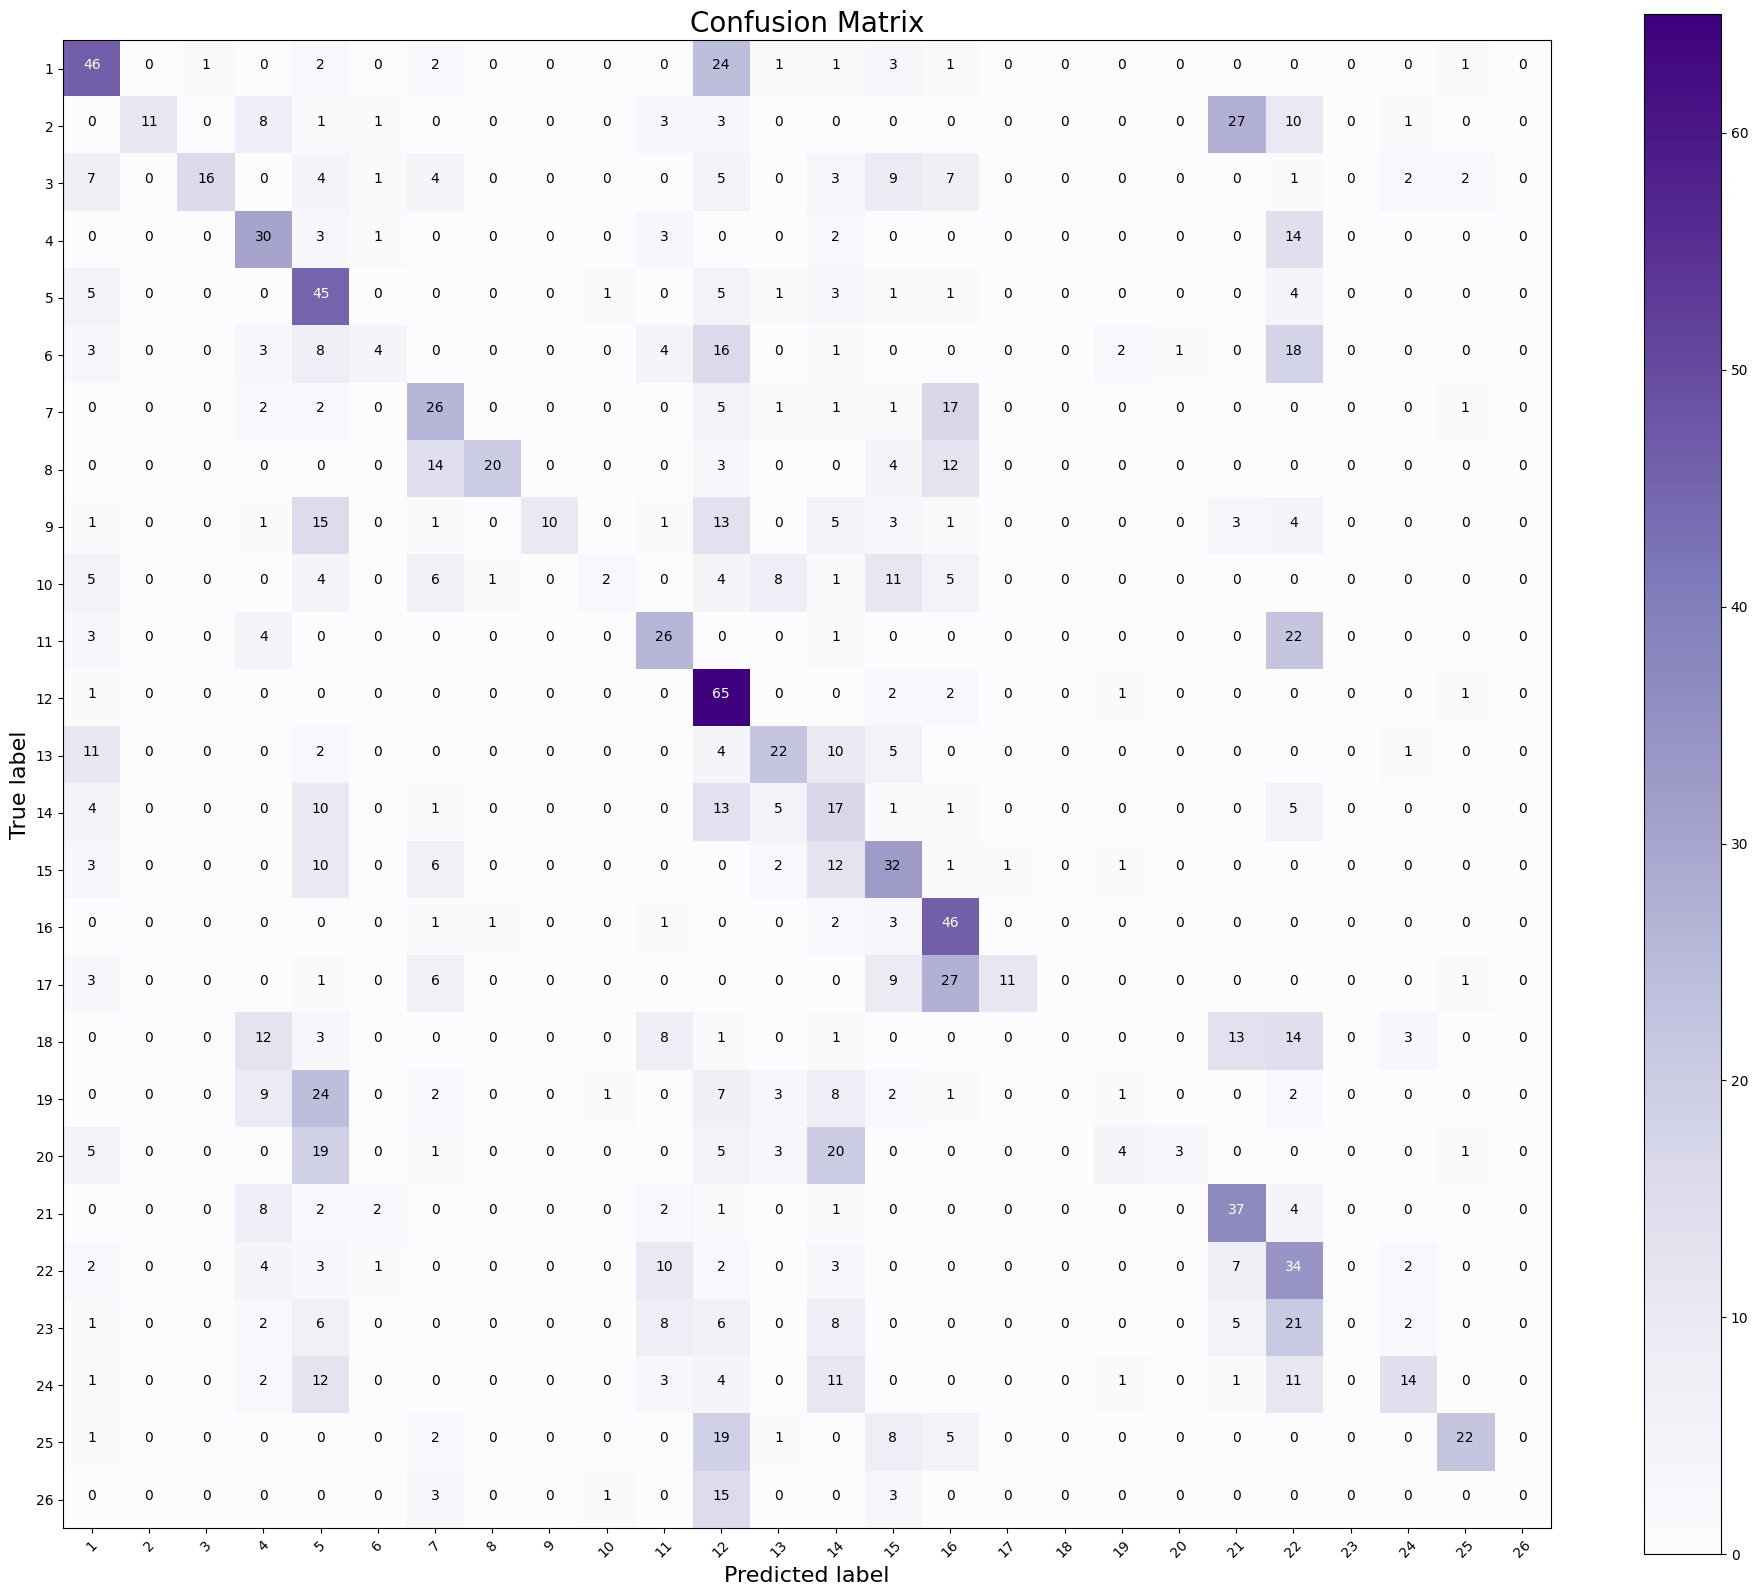

In [63]:
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

from sklearn.metrics import confusion_matrix
import itertools

y_test_pred = model2.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

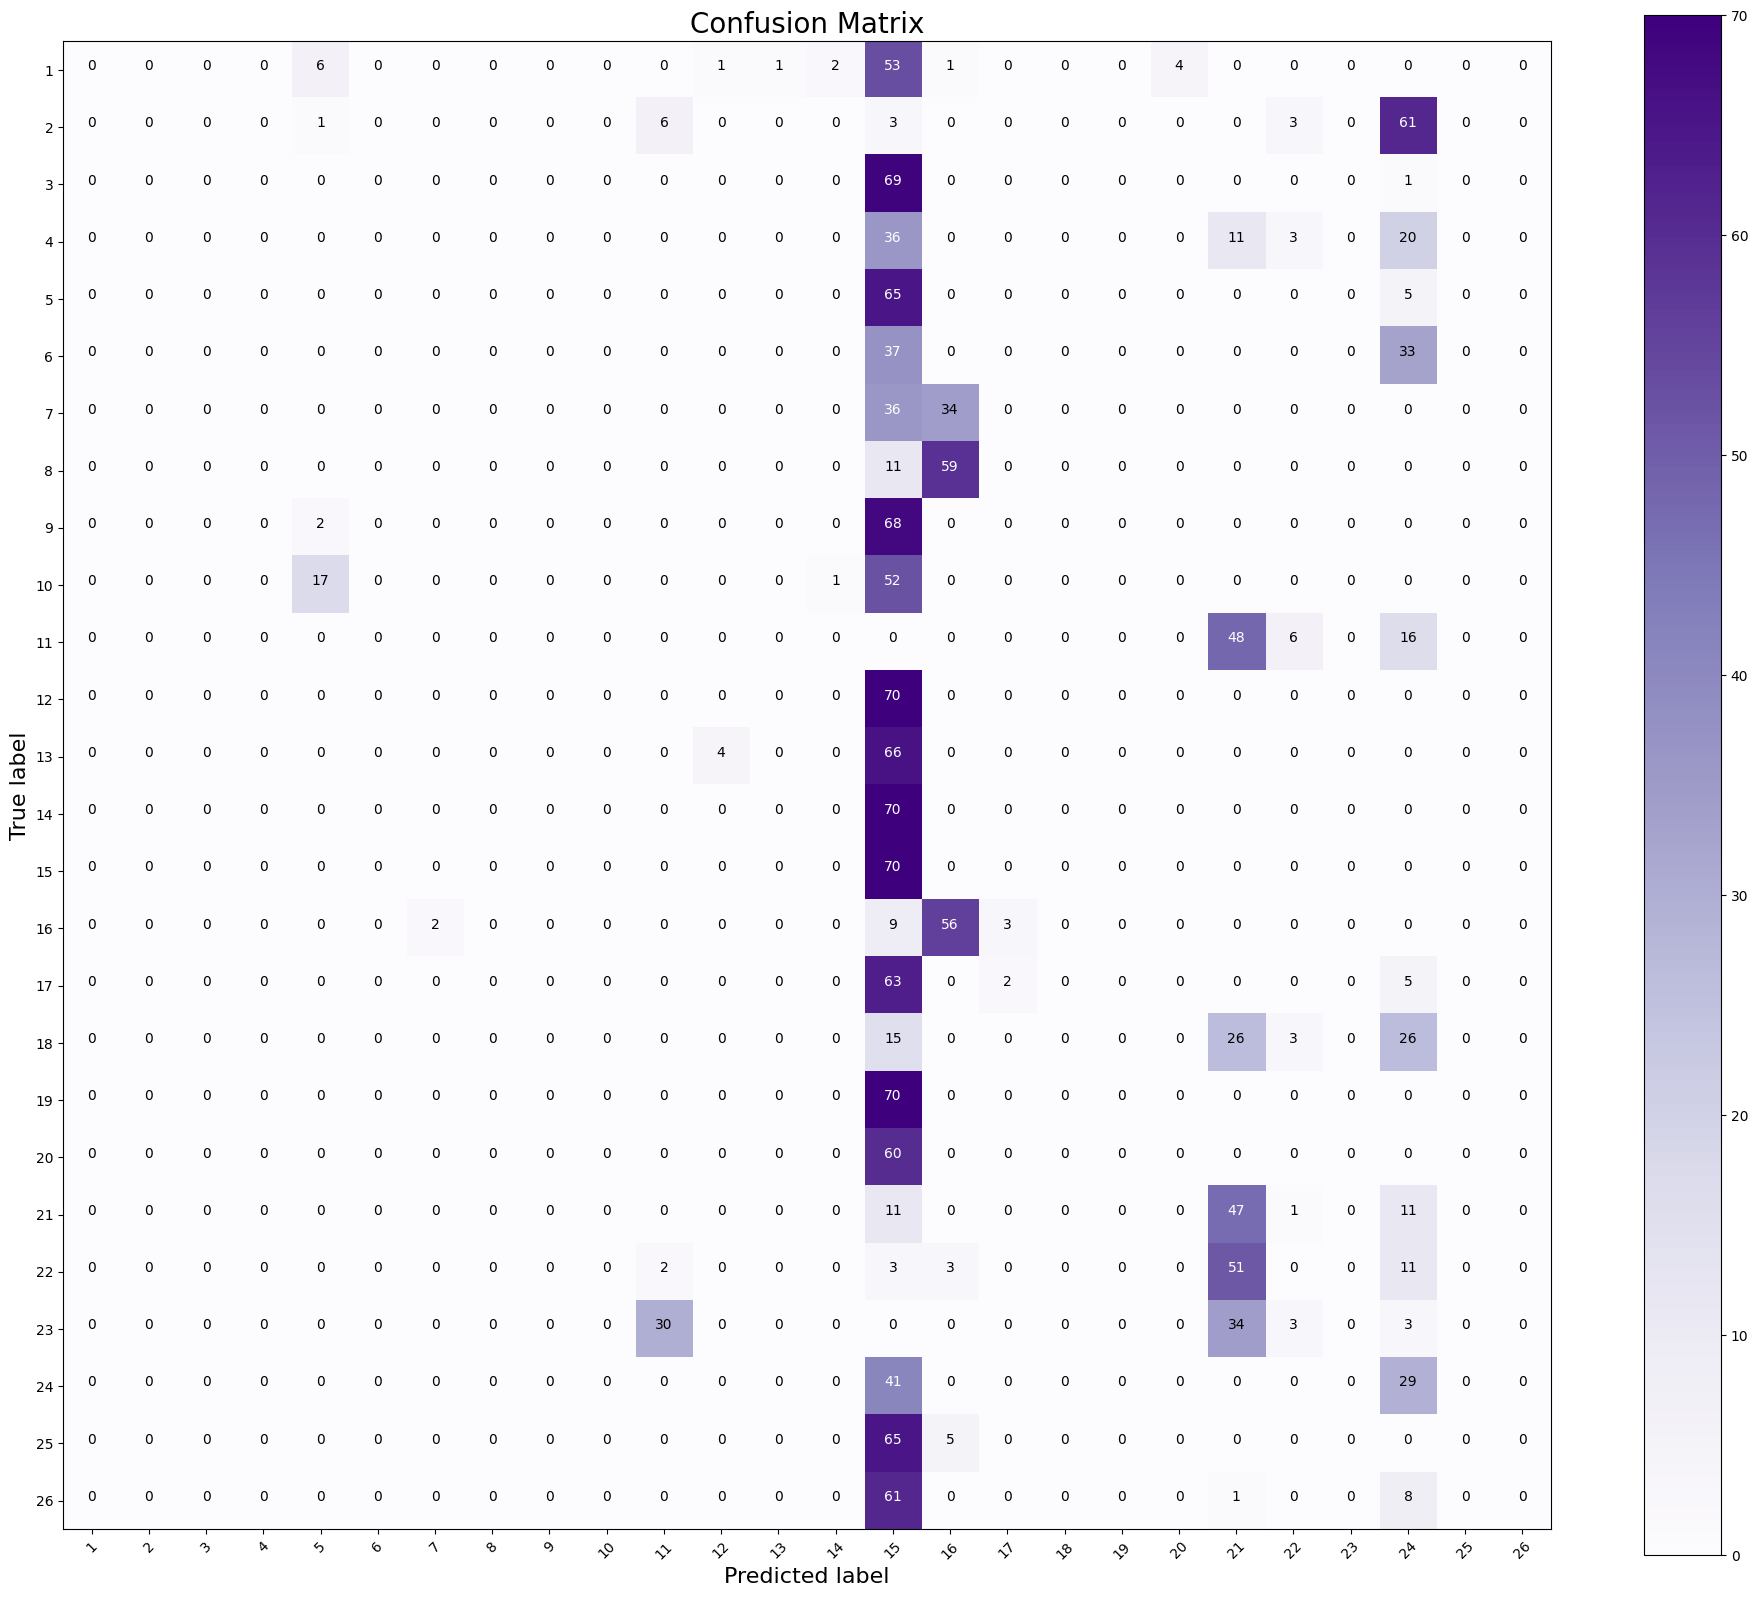

In [64]:
y_eval_pred = model2.predict(X_eval, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_eval, y_eval_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Y


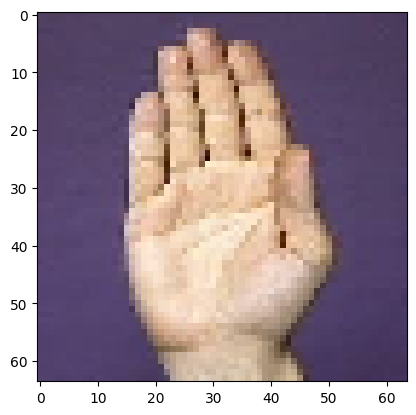

In [65]:
# for only one prediction
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('Download.jpg',target_size=(64,64))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)


if result[0][0] == 1:
    prediction = 'A'
elif result[0][1] == 1:
    prediction = 'B'
elif result[0][2] == 1:
    prediction = 'C'
elif result[0][3] == 1:
    prediction = 'D'
elif result[0][4] == 1:
    prediction = 'E'
elif result[0][5] == 1:
    prediction = 'F'
elif result[0][6] == 1:
    prediction = 'G'
elif result[0][7] == 1:
    prediction = 'H'
elif result[0][8] == 1:
    prediction = 'I'
elif result[0][9] == 1:
    prediction = 'J'
elif result[0][10] == 1:
    prediction = 'K'
elif result[0][11] == 1:
    prediction = 'L'
elif result[0][12] == 1:
    prediction = 'M'
elif result[0][13] == 1:
    prediction = 'N'
elif result[0][14] == 1:
    prediction = 'O'
elif result[0][15] == 1:
    prediction = 'P'
elif result[0][16] == 1:
    prediction = 'Q'
elif result[0][17] == 1:
    prediction = 'R'
elif result[0][18] == 1:
    prediction = 'S'
elif result[0][19] == 1:
    prediction = 'T'
elif result[0][20] == 1:
    prediction = 'U'
elif result[0][21] == 1:
    prediction = 'V'
elif result[0][22] == 1:
    prediction = 'W'
elif result[0][23] == 1:
    prediction = 'X'
elif result[0][24] == 1:
    prediction = 'Y'
elif result[0][25] == 1:
    prediction = 'Z'


else:
    prediction = '  '
    
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Y


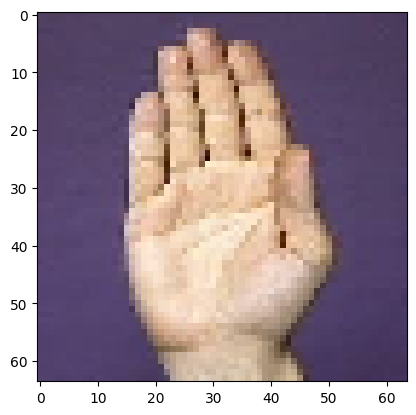

In [67]:
# for only one prediction
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('Download.jpg',target_size=(64,64))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model2.predict(test_image)

if result[0][0] == 1:
    prediction = 'A'
elif result[0][1] == 1:
    prediction = 'B'
elif result[0][2] == 1:
    prediction = 'C'
elif result[0][3] == 1:
    prediction = 'D'
elif result[0][4] == 1:
    prediction = 'E'
elif result[0][5] == 1:
    prediction = 'F'
elif result[0][6] == 1:
    prediction = 'G'
elif result[0][7] == 1:
    prediction = 'H'
elif result[0][8] == 1:
    prediction = 'I'
elif result[0][9] == 1:
    prediction = 'J'
elif result[0][10] == 1:
    prediction = 'K'
elif result[0][11] == 1:
    prediction = 'L'
elif result[0][12] == 1:
    prediction = 'M'
elif result[0][13] == 1:
    prediction = 'N'
elif result[0][14] == 1:
    prediction = 'O'
elif result[0][15] == 1:
    prediction = 'P'
elif result[0][16] == 1:
    prediction = 'Q'
elif result[0][17] == 1:
    prediction = 'R'
elif result[0][18] == 1:
    prediction = 'S'
elif result[0][19] == 1:
    prediction = 'T'
elif result[0][20] == 1:
    prediction = 'U'
elif result[0][21] == 1:
    prediction = 'V'
elif result[0][22] == 1:
    prediction = 'W'
elif result[0][23] == 1:
    prediction = 'X'
elif result[0][24] == 1:
    prediction = 'Y'
elif result[0][25] == 1:
    prediction = 'Z'

    
print(prediction)